In [1]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cv2
import numpy as np
import string
import random

### Read Data from API

In [2]:
document_id = 5
get_document_url = f"http://localhost:8000/document_generator/api/documents/{document_id}"
get_boxes_url = f"http://localhost:8000/document_generator/{document_id}/boxes"

In [3]:
def get_image_and_boxes(document_id: str):
    with requests.Session() as session:
        res_document = session.get(get_document_url)
        res_boxes = session.get(get_boxes_url)
    
        if res_document.status_code == 200 and res_boxes.status_code == 200:
            document_image_url = res_document.json()["image"]
            boxes = res_boxes.json()
            res_image = session.get(document_image_url)
    
            if res_image.status_code == 200:
                image = res_image.content
            else:
                raise ValueError(f"could not retrieve the image error: {res_image.status_code}")
        else:
            raise ValueError(f"could not retrieve the document and the boxes errors: {res_document.status_code}, {res_boxes.status_code}")
    
    return image, boxes

In [4]:
def denormalise_box_coordinates(start_x_norm, start_y_norm, end_x_norm, end_y_norm, doc_width, doc_height):
    start_x = int(start_x_norm * doc_width)
    end_x = int(end_x_norm * doc_width)
    start_y = int(start_y_norm * doc_height)
    end_y = int(end_y_norm * doc_height)
    
    return start_x, start_y, end_x, end_y

In [5]:
document_image_buffer, boxes = get_image_and_boxes(document_id)

In [6]:
document_image = cv2.imdecode(np.frombuffer(document_image_buffer, dtype=np.uint8), flags=cv2.IMREAD_UNCHANGED)

In [7]:
document_image.shape

(1030, 690, 3)

In [8]:
doc_height = document_image.shape[0]
doc_width = document_image.shape[1]

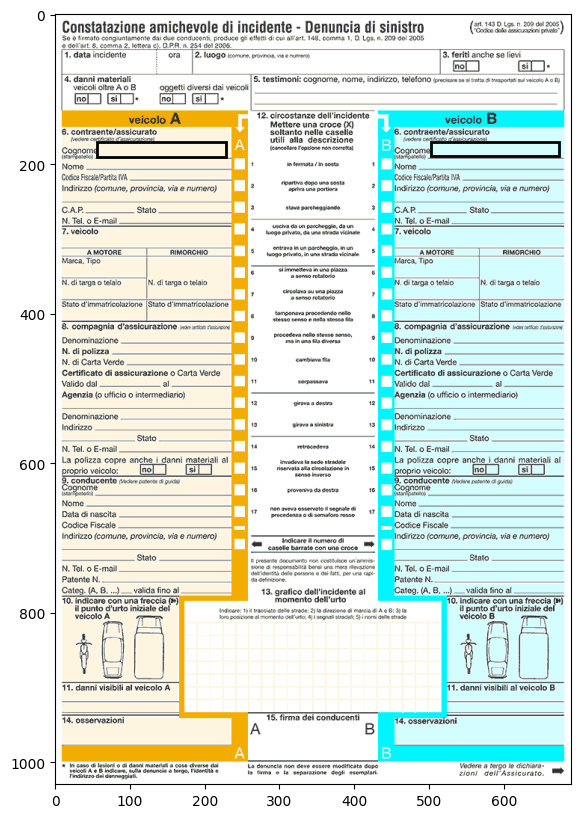

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

# print image
ax.imshow(document_image)

# print boxes
for box in boxes:
    start_x, start_y, end_x, end_y = denormalise_box_coordinates(box["start_x_norm"], box["start_y_norm"], 
                                                                 box["end_x_norm"], box["end_y_norm"],
                                                                 doc_width=doc_width, 
                                                                 doc_height=doc_height)
    x, y, width, height = start_x, start_y, end_x - start_x, end_y - start_y, 
    box_rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(box_rect)

plt.show()

In [10]:
boxes

[{'id': 18,
  'name': 'cognome',
  'is_alphabetic': True,
  'is_numeric': False,
  'mean_length': 5,
  'start_x_norm': 0.08185840707964602,
  'start_y_norm': 0.16592592592592592,
  'end_x_norm': 0.33185840707964603,
  'end_y_norm': 0.18518518518518517,
  'document': 5},
 {'id': 19,
  'name': 'cognome_b',
  'is_alphabetic': True,
  'is_numeric': False,
  'mean_length': 10,
  'start_x_norm': 0.7300884955752213,
  'start_y_norm': 0.16592592592592592,
  'end_x_norm': 0.9778761061946902,
  'end_y_norm': 0.1837037037037037,
  'document': 5}]

In [11]:
labels = pd.read_csv("../data/handwritten_dataset/labels.csv")

### Read letters database

In [12]:
labels.head()

,image,label
0,images/img001-001.png,0
1,images/img001-002.png,0
2,images/img001-003.png,0
3,images/img001-004.png,0
4,images/img001-005.png,0


In [13]:
labels[labels["label"] == "1"].head(2)

,image,label
55,images/img002-001.png,1
56,images/img002-002.png,1


In [10]:
letter_image_0 = cv2.imread("../data/handwritten_dataset_processed/images/img001-001.png", flags=cv2.IMREAD_UNCHANGED)

In [11]:
letter_image_1 = cv2.imread("../data/handwritten_dataset_processed/images/img002-001.png", flags=cv2.IMREAD_UNCHANGED)

In [12]:
letter_0_height = letter_image_0.shape[0]

In [13]:
letter_1_height = letter_image_1.shape[0]

In [14]:
max_height = max(letter_0_height, letter_1_height)

In [16]:
letter_0_height, letter_1_height

(586, 494)

In [17]:
max_height

586

In [27]:
images_to_concat = [letter_image_0, letter_image_1]
images_to_concat_padded = []
images_to_concat_scaled = []

# pad images to fit the largest one
for image in images_to_concat:
    pad_height = max_height - image.shape[0]
    
    padded_image = cv2.copyMakeBorder(
        image,
        top=pad_height, bottom=0, left=0, right=0,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0, 0]  # Transparent (RGBA)
    )

    images_to_concat_padded.append(padded_image)

# scale images to fit the largest one
for image in images_to_concat:
    image_width = image.shape[1]
    image_height = image.shape[0]
    scale_factor = max_height / image_height
    
    new_width = int(image_width * scale_factor)
    new_height = int(image_height * scale_factor)
    
    letter_scaled = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    images_to_concat_scaled.append(letter_scaled)

In [28]:
images_to_concat_padded[0].shape

(586, 411, 4)

In [29]:
images_to_concat_padded[1].shape

(586, 181, 4)

In [30]:
images_to_concat_scaled[0].shape

(586, 411, 4)

In [31]:
images_to_concat_scaled[1].shape

(586, 214, 4)

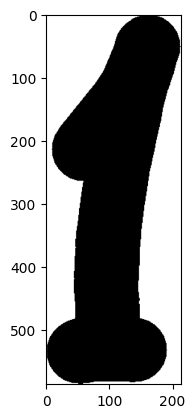

In [32]:
plt.imshow(images_to_concat_scaled[1])

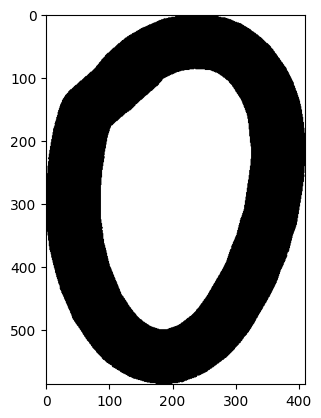

In [33]:
plt.imshow(images_to_concat_scaled[0])

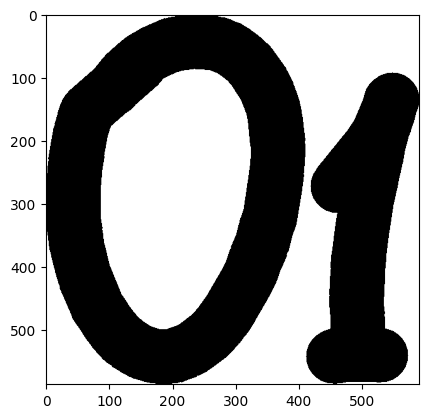

In [34]:
plt.imshow(cv2.hconcat(images_to_concat_padded))

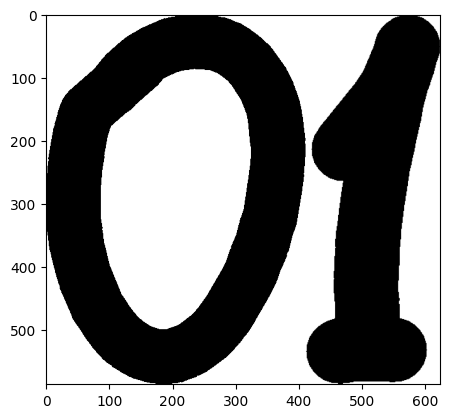

In [35]:
plt.imshow(cv2.hconcat(images_to_concat_scaled))

### Generate samples

In [14]:
def generate_random_string(length, is_alphabetic, is_numeric):
    characters = ''
    
    if is_alphabetic:
        characters += string.ascii_uppercase
    
    if is_numeric:
        characters += string.digits
    
    return ''.join(random.choices(characters, k=length))

In [15]:
def overlay_image(background, overlay, position):
    """
    Overlay one image on top of another at a specific position.

    Args:
        background: Background image (BGR or BGRA format).
        overlay: Overlay image (BGR or BGRA format).
        position: Tuple (x, y) for the top-left corner where the overlay will be placed.

    Returns:
        Resultant image with the overlay.
    """
    x, y = position
    h, w = overlay.shape[:2]

    # If overlay has alpha channel, handle transparency
    if overlay.shape[2] == 4:
        # Split the overlay into RGB and alpha channels
        overlay_rgb = overlay[:, :, :3]
        alpha = overlay[:, :, 3] / 255.0  # Normalize alpha to [0, 1]

        # Extract the region of interest from the background
        roi = background[y:y+h, x:x+w]

        # Blend the overlay with the region of interest
        blended = (1.0 - alpha[..., None]) * roi + alpha[..., None] * overlay_rgb

        # Replace the region in the background with the blended image
        background[y:y+h, x:x+w] = blended.astype(np.uint8)
    else:
        # If no alpha channel, directly replace the region
        background[y:y+h, x:x+w] = overlay

    
    return background

In [18]:
def get_rand_string_image(rand_string):
    images_to_concat = []

    # select random images from handwritten dataset for each letter
    for character in rand_string:
        character_image_path = labels[labels["label"] == character].sample(n=1)["image"].iloc[0]
    
        character_image = cv2.imread(f"../data/handwritten_dataset_processed/{character_image_path}", flags=cv2.IMREAD_UNCHANGED)
        images_to_concat.append(character_image)

    # pad images to fit the largest one
    max_height = max(map(lambda x: x.shape[0], images_to_concat))
    images_to_concat_padded = []
    
    for image in images_to_concat:
        pad_height = max_height - image.shape[0]
        
        padded_image = cv2.copyMakeBorder(
            image,
            top=pad_height, bottom=0, left=0, right=0,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0, 0]  # Transparent (RGBA)
        )

        images_to_concat_padded.append(padded_image)

    return cv2.hconcat(images_to_concat_padded)

In [19]:
document_with_strings = document_image.copy()

for box in boxes:
    string_length = int(np.random.normal(box['mean_length'], 1))
    rand_string = generate_random_string(string_length, box['is_alphabetic'], box['is_numeric'])

    rand_string_image = get_rand_string_image(rand_string)

    start_x, start_y, end_x, end_y = denormalise_box_coordinates(box["start_x_norm"], box["start_y_norm"], 
                                                                 box["end_x_norm"], box["end_y_norm"],
                                                                 doc_width=doc_width, 
                                                                 doc_height=doc_height)

    box_width = end_x - start_x
    box_height = end_y - start_y
    string_height, string_width = rand_string_image.shape[:2]
    
    # Calculate the scaling factor
    scale_w = box_width / string_width
    scale_h = box_height / string_height
    scale = min(scale_w, scale_h)
    
    # Calculate new dimensions
    new_width = int(string_width * scale)
    new_height = int(string_height * scale)
    
    # Resize the image
    rand_string_image_scaled = cv2.resize(rand_string_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    document_with_strings = overlay_image(background=document_with_strings, overlay=rand_string_image_scaled, position=(start_x, start_y))

AttributeError: module 'cv2' has no attribute 'BRG2RGB'

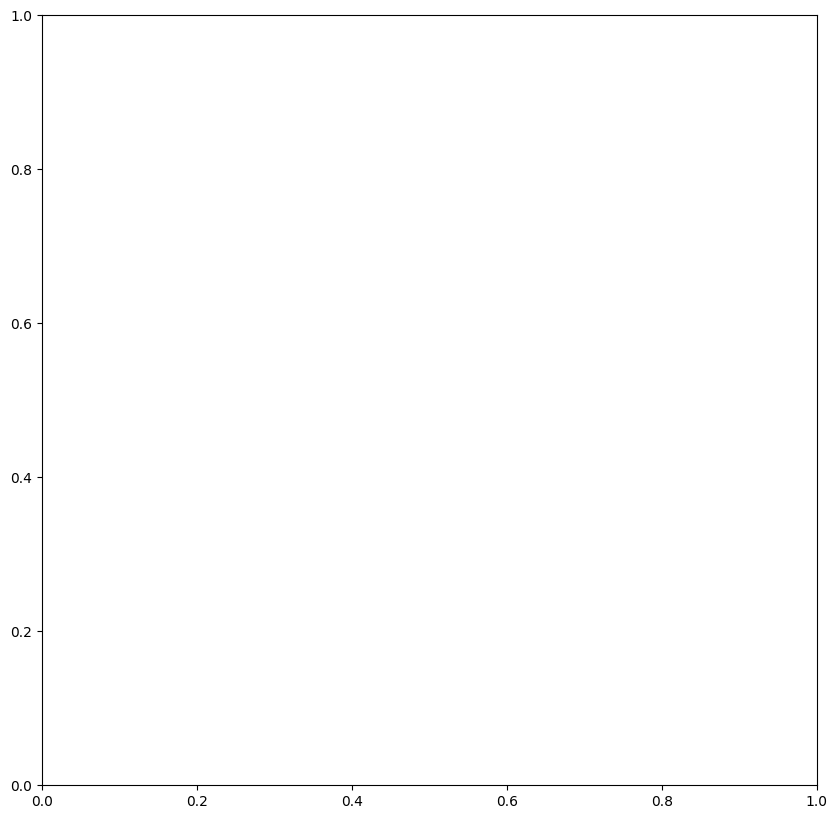

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(cv2.cvtColor(document_with_strings, cv2.BRG2RGB))
plt.show()

In [66]:
cv2.imwrite(f"../data/sample_1.png", document_with_strings)

True